#### Data Analytics

# ACT General Health Survey (ACT GHS) 2011-2020

<img src="Images/ACT_Government_logo.svg" style="float: right; padding-top: 10px; padding-left: 10px;" alt="airbnb logo" width="180"/>
<br>

<!-- The logo image needs licensing. Check: https://en.wikipedia.org/wiki/File:ACT_Government_logo.svg -->

Some topics and questions that will concern us:

<!--
- Let's say, you want to visit Berlin and plan to stay overnight.
    - Where are most accommodations listed within Berlin?
    - Are there districts more expensive than others?
    - How much more expensive are appartments in comparison to a single room?
    - Over the course of the year, are there times with peaks in tourism that I can avoid if I don't like crowds?
- Real estate businesses moving over to Airbnb.
    - Among the hosts of Airbnb listings, are there many professional businesses in Berlin or is it just people who share their room?
    - Did many hotel businesses join Airbnb for Berlin?
    - How does the pandemic in 2020 affect the data? -->

## Imports
First, we'll need to import some modules that we are going to use

In [49]:
# Data Handling
import pandas as pd
import numpy as np

# Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Surpress IPython warnings
import warnings
warnings.filterwarnings("ignore")

## Data Acquisition 

We are going to use the data provided by [ACT Government](https://www.data.act.gov.au/Health/ACT-General-Health-Survey-ACT-GHS-2011-2020/63ts-nstx).


In [50]:
data_directory = 'Data'

We now load the data set into pandas:
- `ACT_General_Health_Survey_2011-2020.csv`: **listings data**: each entry represents a respondent that took part in the ACT General Health Survey

In [51]:
# Load listings data set
df_listings = pd.read_csv(f"{data_directory}/ACT_General_Health_Survey_2011-2020.csv", 
                          sep=',', quotechar='"')

### Missing values 
Is there anything missing in the DataFrames

In [52]:
df_listings.isna().sum()

Year                0
Region              0
Category            0
Topic               7
Indicator           0
Age                 0
Sex                 0
Result             54
Unit                0
95% CI (L)         54
95% CI (U)         54
SE                 54
RSE > 25%        1464
Notes            1515
Sex_indicator       0
Year_Sex            0
Sex_Year            0
dtype: int64

How do these counts look in the bigger picture. We certainty can visualize the ratio: 

In [53]:
# Change figure size for printing
sns.set(rc={'figure.figsize':(11.7,8.27)})

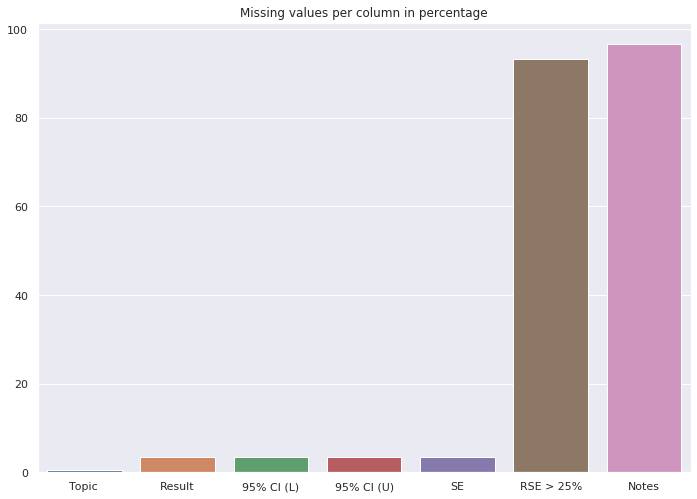

In [54]:
# Calculate percentage of missing values for each column
df_miss_perc = df_listings.isna().mean() * 100

# Drop columns without missing values
miss_perc = df_miss_perc[df_miss_perc > 0]

if len(miss_perc) == 0:
    raise Exception('no missing values!')

ax = sns.barplot(x=miss_perc.index, y=miss_perc.values)
foo = ax.set_title("Missing values per column in percentage")

There are 7 columns affected by missing values in our listing data set. 
While `Topic`, `Result`, `95% CI (L)`, `95% CI (U)`, and `SE` have very few occurences (`Topic` less than 1%, `Result`, `95% CI (L)`, `95% CI (U)`, and `SE` less than 3.5%) of missing values, `RSE > 25%` and `Notes` on the contrary have between 80% and 100% data missing respectively. For the first column, we could either drop the rows affected or deal with it later - 1% is negligible. For the second to fourth columns, we may need to drop the affected columns - 3% is not negligible. However, 80-100% is a different story. Spoiler: we won't use the later two columns and we also don't care about whether some of our rows will have data mising for these attributes either.

We'll be using `Topic`, `Result`, `95% CI (L)`, `95% CI (U)`, and `SE` though, so please drop the rows affected by missing `Topic`, `Result`, `95% CI (L)`, `95% CI (U)`, and `SE` s (and only those)!

In [55]:
rows_before = df_listings.shape[0]

df_listings.dropna(subset=['Topic','Result',
                           '95% CI (L)','95% CI (U)','SE'], inplace=True)

rows_after = df_listings.shape[0]
print(f"{rows_before} ➜ {rows_after} ({rows_before - rows_after} rows dropped)")

1568 ➜ 1507 (61 rows dropped)


## Data Cleaning ⇌ EDA ⇌ Data Modelling

For the most part, we'll be supported by the most prevalent tasks when analysing data. We'll not enforce any order and jumping back and forth may also happen. 

- **Data Cleaning**: removing faulty values & dealing with missing data

- **Exploratory Data Analysis (EDA)**: investigating the data & observing patterns

- **Data Modelling**: ordering & highlighting the data with visualizations  

### Listings Data Set

The `shape` of the DataFrame:

In [37]:
# df_listings.info(verbose=False)
df_listings.shape

(1507, 17)

The listings data set contains 1507 samples and the samples are described by 17 columns.

The first five rows:

In [40]:
Adf_listings.head()

,Year,Region,Category,Topic,Indicator,Age,Sex,Result,Unit,95% CI (L),95% CI (U),SE,RSE > 25%,Notes,Sex_indicator,Year_Sex,Sex_Year
0,2011/12,ACT,Health,Self-rated health,1. Excellent/very good,05 to 17,Person,72.2,Per cent,68.1,76.0,2.0,NaN,NaN,Person _ 1. Excellent/very good,2011/12 Person,Person 2011/12
1,2013/14,ACT,Health,Self-rated health,1. Excellent/very good,05 to 17,Person,73.2,Per cent,68.6,77.3,2.2,NaN,NaN,Person _ 1. Excellent/very good,2013/14 Person,Person 2013/14
2,2015/16,ACT,Health,Self-rated health,1. Excellent/very good,05 to 17,Person,74.8,Per cent,70.4,78.7,2.1,NaN,NaN,Person _ 1. Excellent/very good,2015/16 Person,Person 2015/16
3,2018,ACT,Health,Self-rated health,1. Excellent/very good,05 to 17,Person,78.1,Per cent,71.5,83.5,3.0,NaN,NaN,Person _ 1. Excellent/very good,2018 Person,Person 2018
4,2020,ACT,Health,Self-rated health,1. Excellent/very good,05 to 17,Person,79.6,Per cent,76.1,82.7,1.7,NaN,NaN,Person _ 1. Excellent/very good,2020 Person,Person 2020


A sample in this DataFrame represents a respondent. It includes the health data categorized.

In [38]:
df_listings.columns

Index(['Year', 'Region', 'Category', 'Topic', 'Indicator', 'Age', 'Sex',
       'Result', 'Unit', '95% CI (L)', '95% CI (U)', 'SE', 'RSE > 25%',
       'Notes', 'Sex_indicator', 'Year_Sex', 'Sex_Year'],
      dtype='object')

We should isolate the columns into different categories:

- Basic information on the listing recorded
    - `Year`: year at which sample was taken
    - `Region`: region at which sample was taken
- Information about the sample type and indicators
    - `Category`: Risk Factor Category
    - `Topic`: Specific Risk Factor Description 
    - `Indicator`: Specific Risk Factor Indicator
- Age and sex of the respondents
    - `Age`: age of the respondents
    - `Sex`: sex of the respondents
- Result information on the specific sample and indicators 
    - `Result`: a number indicating a result
    - `Unit`: unit of the result based on the specific sample and indicator
    - `95% CI (L)`: Lower 95% confidence interval
    - `95% CI (U)`: Upper 95% confidence interval
    - `SE`: standard error of the result
- Information on sex
    - `Sex_indicator`: sex of the respondent and the wellbeing index of having sex
    - `Year_Sex`: year at which the respondent engages sex and the sex of the respondent
    - `Sex_Year`: sex of the respondent and the year at which the respondent engages sex
 

## Aggregate the listings by grouping via `Category` and count their rows. 

In [42]:
df_listings.groupby(by='Category').count()

,Year,Region,Topic,Indicator,Age,Sex,Result,Unit,95% CI (L),95% CI (U),SE,RSE > 25%,Notes,Sex_indicator,Year_Sex,Sex_Year
Category,,,,,,,,,,,,,,,,
Alcohol,58,58,58,58,58,58,58,58,58,58,58,1,0,58,58,58
Discrimination,17,17,17,17,17,17,17,17,17,17,17,1,0,17,17,17
E-Cigarettes,12,12,12,12,12,12,12,12,12,12,12,0,0,12,12,12
Health,176,176,176,176,176,176,176,176,176,176,176,6,0,176,176,176
Mental health,345,345,345,345,345,345,345,345,345,345,345,32,0,345,345,345
Nutrition,187,187,187,187,187,187,187,187,187,187,187,12,0,187,187,187
Oral health,72,72,72,72,72,72,72,72,72,72,72,12,0,72,72,72
Physical activity,149,149,149,149,149,149,149,149,149,149,149,5,0,149,149,149
Sedentary behaviour,61,61,61,61,61,61,61,61,61,61,61,4,0,61,61,61


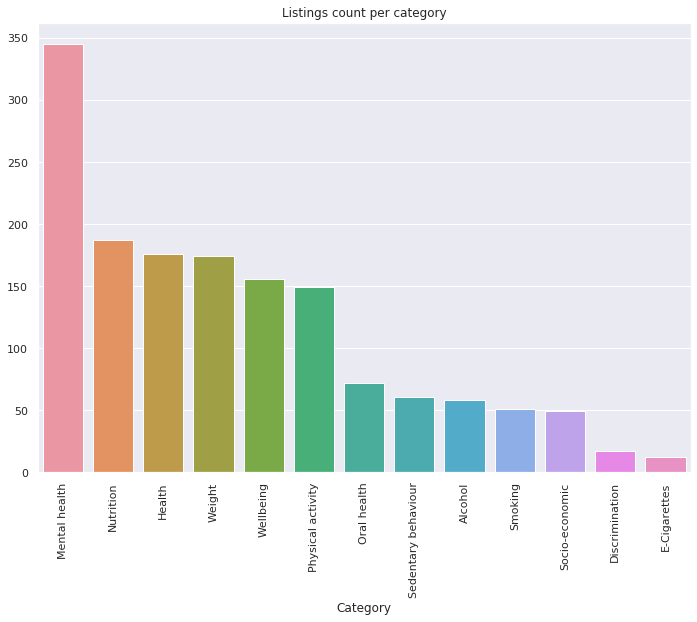

In [45]:
# Count the listings per category
count_per_category = df_listings.groupby(by='Category').count()['Year']

# Plot the data
ax = sns.barplot(
    x=count_per_category.index,
    y=count_per_category.values,
    order=count_per_category.sort_values(ascending=False).index
)
foo = ax.set_title("Listings count per category")
foo = plt.xticks(rotation=90)

## Aggregate the listings by grouping via `Topic` and count their rows. 

In [44]:
df_listings.groupby(by='Topic').count()

,Year,Region,Category,Indicator,Age,Sex,Result,Unit,95% CI (L),95% CI (U),SE,RSE > 25%,Notes,Sex_indicator,Year_Sex,Sex_Year
Topic,,,,,,,,,,,,,,,,
Active travel,36,36,36,36,36,36,36,36,36,36,36,0,0,36,36,36
Adult physical activity guideline,35,35,35,35,35,35,35,35,35,35,35,0,0,35,35,35
Alcohol consumption,24,24,24,24,24,24,24,24,24,24,24,1,0,24,24,24
BMI category,127,127,127,127,127,127,127,127,127,127,127,15,0,127,127,127
Child physical activity guideline,15,15,15,15,15,15,15,15,15,15,15,0,0,15,15,15
Cigarettes,6,6,6,6,6,6,6,6,6,6,6,0,0,6,6,6
Disability,9,9,9,9,9,9,9,9,9,9,9,0,0,9,9,9
Fast food,57,57,57,57,57,57,57,57,57,57,57,0,0,57,57,57
Feels safe after dark,19,19,19,19,19,19,19,19,19,19,19,0,0,19,19,19


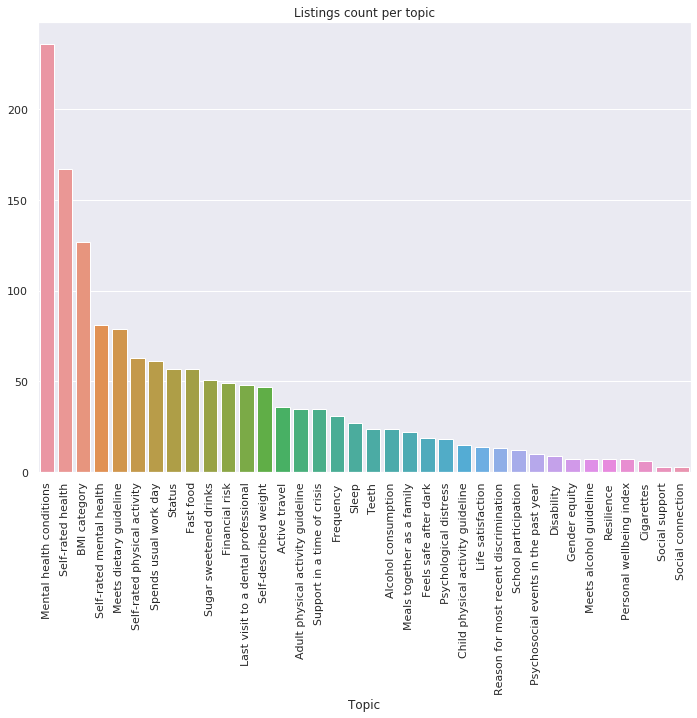

In [46]:
# Count the listings per topic
count_per_topic = df_listings.groupby(by='Topic').count()['Year']

# Plot the data
ax = sns.barplot(
    x=count_per_topic.index,
    y=count_per_topic.values,
    order=count_per_topic.sort_values(ascending=False).index
)
foo = ax.set_title("Listings count per topic")
foo = plt.xticks(rotation=90)